In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
import scipy.stats

In [3]:
def compute_ci_width( data_pts ):
    se = scipy.stats.sem(data_pts)
    return se * scipy.stats.t.ppf((1 + 0.95) / 2., len(data_pts)-1)

## Checkpoint Throughput over Time

In [127]:
dendrite_pin_data = np.array([2177.6742458332997, 2265.2140726206417, 2187.1474802300095])
dendrite_pin_tput = np.mean(dendrite_pin_data)
dendrite_pin_ci = compute_ci_width(dendrite_pin_data)

dendrite_log_data = np.array([2200.5145569615356, 2368.9244602899144, 2266.624878386653])
dendrite_log_tput = np.mean(dendrite_log_data)
dendrite_log_ci = compute_ci_width(dendrite_log_data)

default_postgresql_data = np.array([850.9203353251161, 741.1416447307269, 878.5428654703571])
default_postgresql_tput = np.mean(default_postgresql_data)
default_postgresql_ci = compute_ci_width(default_postgresql_data)

In [128]:
dendrite_log_tput/default_postgresql_tput

2.766959640679459

In [129]:
dendrite_pin_tput/default_postgresql_tput

2.6835678763804323

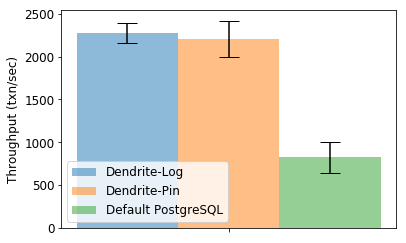

In [78]:
inds = np.arange(1)
bar_width=0.2
plt.bar( inds-bar_width, [dendrite_log_tput], bar_width, yerr=(dendrite_pin_ci,), capsize=10, label="Dendrite-Log", alpha=0.5,  )
plt.bar( inds, [dendrite_pin_tput], bar_width, yerr=(dendrite_log_ci,), capsize=10, label="Dendrite-Pin", alpha=0.5 )
plt.bar( inds+bar_width, [default_postgresql_tput], bar_width, yerr=(default_postgresql_ci,), capsize=10, label="Default PostgreSQL", alpha=0.5 )
plt.legend( loc='lower left', fontsize=12)
plt.yticks( fontsize=12 )
plt.xticks(inds, [""])
plt.ylabel( "Throughput (txn/sec)", fontsize=12)
#plt.xlabel( "System", fontsize=12 )
plt.savefig( "checkpoint_tput.png", bbox_inches='tight')
plt.show()

## Checkpoint Latency over Time

### Dendrite-PIN

In [79]:
def get_lats_from_file( fname ):
    with open( fname, "r" ) as f:
        lats = []
        for line in f:
            lats.append( float(line.strip()) )
    return lats

def stack_lats_as_matrix( multi_lats_list ):
    mat = []
    min_len = min(map( len, multi_lats_list ))
    for i in range(min_len):
        mat_row = []
        for lats_list_ind in range(len(multi_lats_list)):
            mat_row.append( multi_lats_list[lats_list_ind][i])
        mat.append( mat_row )
    return np.array( mat )

def create_lats_matrix( *fnames ):
    multi_lats_list = []
    for fname in fnames:
        multi_lats_list.append( get_lats_from_file( fname ) )
    return stack_lats_as_matrix( multi_lats_list )


In [80]:
lats_matrix = create_lats_matrix( "periodic_lats.logadapt.1", "periodic_lats.logadapt.2", "periodic_lats.logadapt.3")
epoch_lat_means_logadapt = np.mean( lats_matrix, axis=1 )
lats_matrix = create_lats_matrix( "periodic_lats.adapt.1", "periodic_lats.adapt.2", "periodic_lats.adapt.3")
epoch_lat_means_adapt = np.mean( lats_matrix, axis=1 )
lats_matrix = create_lats_matrix( "periodic_lats.noadapt.1", "periodic_lats.noadapt.2", "periodic_lats.noadapt.3")
epoch_lat_means_noadapt = np.mean( lats_matrix, axis=1 )

#Rescale to ms from us
epoch_lat_means_logadapt /= 1000
epoch_lat_means_adapt /= 1000
epoch_lat_means_noadapt /= 1000

In [81]:
min_len = min(map(len, [epoch_lat_means_logadapt, epoch_lat_means_adapt, epoch_lat_means_noadapt]))
epochs = np.arange(0,min_len)
epoch_lat_means_logadapt = epoch_lat_means_logadapt[:min_len]
epoch_lat_means_adapt = epoch_lat_means_adapt[:min_len]
epoch_lat_means_noadapt = epoch_lat_means_noadapt[:min_len]

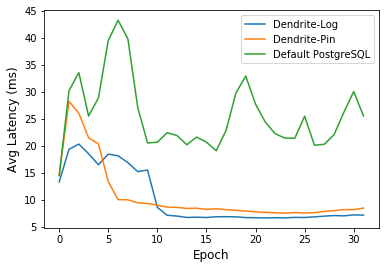

In [83]:
plt.plot( epochs[:32], epoch_lat_means_logadapt[:32], label="Dendrite-Log" )
plt.plot( epochs[:32], epoch_lat_means_adapt[:32], label="Dendrite-Pin" )
plt.plot( epochs[:32], epoch_lat_means_noadapt[:32], label="Default PostgreSQL" )
plt.legend(fontsize=10)
plt.xlabel( "Epoch", fontsize=12)
plt.ylabel( "Avg Latency (ms)", fontsize=12)
plt.savefig("checkpt_pin_lat.png", bbox_inches='tight')
plt.show()

## HTAP Scenario

### Dendrite-PIN

In [11]:
## N.B. LOG version has no autovac or checkpoint on, so tput is like double. May also affect OLAP lats. Should re-run the others with autovac/checkpt off.

In [12]:
adapt_tputs = np.array([933.918871721404, 827.8659866714344,920.3037513192015])
no_adapt_tputs = np.array([817.6137289790363,782.8905565476018,785.3934226415871])
adapt_tput_mean = np.mean(adapt_tputs)
no_adapt_tput_mean = np.mean(no_adapt_tputs)

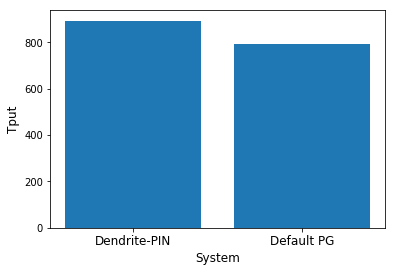

In [13]:
x_inds = np.arange(0,2)
labels = [ "Dendrite-PIN", "Default PG"]
plt.bar(x_inds, [adapt_tput_mean, no_adapt_tput_mean])
plt.xticks( x_inds, labels, fontsize=12 )
plt.ylabel( "Tput", fontsize=12)
plt.xlabel( "System", fontsize=12 )
plt.savefig( "htap_tput.png", bbox_inches='tight')
plt.show()

In [95]:
adapt_olap_lats = np.array([416412, 408995, 404985])/1000
adapt_olap_log_lats = np.array([404580, 407717, 409513])/1000
no_adapt_olap_lats = np.array([1.26761e+07, 1.57031e+07, 1.35248e+07])/1000

In [96]:
adapt_lat_mean = np.mean(adapt_olap_lats)
adapt_log_lat_mean = np.mean(adapt_olap_log_lats)
no_adapt_lat_mean = np.mean(no_adapt_olap_lats)
adapt_lat_ci = compute_ci_width(adapt_olap_lats)
adapt_log_lat_ci = compute_ci_width(adapt_olap_log_lats)
no_adapt_lat_ci = compute_ci_width(no_adapt_olap_lats)

In [101]:
no_adapt_lat_mean/adapt_log_lat_mean

34.29665823655069

In [126]:
no_adapt_lat_mean/adapt_lat_mean

34.057438604932415

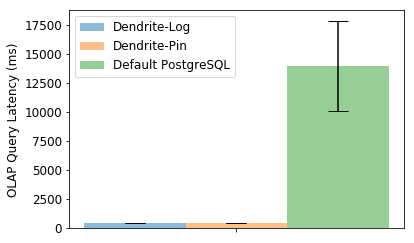

In [60]:
inds = np.arange(1)
bar_width=0.2
plt.bar( inds-bar_width, [adapt_log_lat_mean], bar_width, yerr=(adapt_log_lat_ci,), capsize=10, label="Dendrite-Log", alpha=0.5,  )
plt.bar( inds, [adapt_lat_mean], bar_width, yerr=(adapt_lat_ci,), capsize=10, label="Dendrite-Pin", alpha=0.5 )
plt.bar( inds+bar_width, [no_adapt_lat_mean], bar_width, yerr=(no_adapt_lat_ci,), capsize=10,label="Default PostgreSQL", alpha=0.5 )
plt.legend(fontsize=12)
plt.yticks( fontsize=12 )
plt.xticks(inds, [""])
plt.ylabel( "OLAP Query Latency (ms)", fontsize=12)
#plt.xlabel( "System", fontsize=12 )
plt.savefig( "htap_qry_lat.png", bbox_inches='tight')
plt.show()

## SQLite Batching

/opt/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


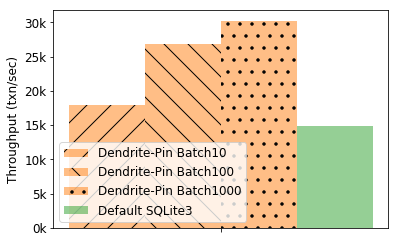

In [102]:
default_sqlite_txns = np.mean([12779.8+2081.94, 13097 + 2136.54, 12652.1 + 2058.85])/1000.
dendrite_batch10_txns = np.mean([15211.4 + 2717.55, 15117.8 + 2700.34, 15297.5 + 2724.03 ])/1000.
dendrite_batch100_txns = np.mean([22557.8 + 4535.46, 22225.6 + 4474.87, 22378.2 + 4503.1 ])/1000.
dendrite_batch1000_txns = np.mean([25305.3 + 5207.88, 24779.2 + 5105.93, 25175.6 + 5185.64 ])/1000.

def k_txn_writer( x, pos ):
    return "{}k".format(int(x))

inds = np.arange(1)
bar_width=0.2
plt.bar( inds-bar_width*2, dendrite_batch10_txns, bar_width, color='#ff7f0e', hatch='/', alpha=0.5, label='Dendrite-Pin Batch10' )
plt.bar( inds-bar_width, dendrite_batch100_txns, bar_width, color='#ff7f0e', hatch='\\', alpha=0.5, label='Dendrite-Pin Batch100' )
plt.bar( inds, dendrite_batch1000_txns, bar_width, color='#ff7f0e', hatch='.', alpha=0.5, label='Dendrite-Pin Batch1000' )
plt.bar( inds+bar_width, default_sqlite_txns, bar_width, color='#2ca02c', alpha=0.5, label='Default SQLite3' )
plt.ylabel( "Throughput (txn/sec)", fontsize=12 )
ax = plt.axes()
ax.yaxis.set_major_formatter( tick.FuncFormatter(k_txn_writer))
plt.yticks( fontsize=12 )
plt.xticks( inds-bar_width/2, [""] )
plt.legend( loc='lower left', ncol=1, fontsize=12)
plt.savefig( 'sqlite_pin_perf.png', bbox_inches='tight')
plt.show()

In [125]:
print(dendrite_batch10_txns/default_sqlite_txns)
print(dendrite_batch100_txns/default_sqlite_txns)
print(dendrite_batch1000_txns/default_sqlite_txns)

1.2000255321637192
1.8005315332265182
2.0256011273432293


## Index Creation

/opt/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


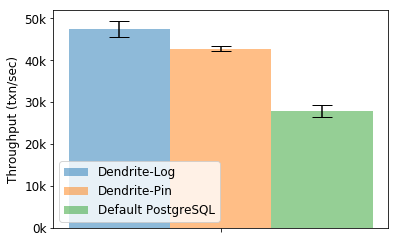

In [90]:
dendrite_log_tputs = np.array([47063.80755566226,48396.97784704293, 47012.607235797215])/1000.
dendrite_log_tput = np.mean( dendrite_log_tputs )
dendrite_log_ci = compute_ci_width( dendrite_log_tputs )
dendrite_pin_tputs = np.array([43011.27152254561, 42614.17615704967, 42565.78952653924])/1000.
dendrite_pin_tput = np.mean( dendrite_pin_tputs )
dendrite_pin_ci = compute_ci_width( dendrite_pin_tputs )
default_postgresql_tputs = np.array([27566.306884629,27450.0078853033, 28527.629633569686])/1000.
default_postgresql_tput = np.mean( default_postgresql_tputs )
default_postgresql_ci = compute_ci_width( default_postgresql_tputs )

## FIXME: Need Dendrite-Log Results
def k_txn_writer( x, pos ):
    return "{}k".format(int(x))

inds = np.arange(1)
bar_width=0.2
plt.bar( inds-bar_width, dendrite_log_tput, bar_width, yerr=(dendrite_log_ci,), capsize=10, alpha=0.5, label='Dendrite-Log' )
plt.bar( inds, dendrite_pin_tput, bar_width, yerr=(dendrite_pin_ci,), capsize=10, alpha=0.5, label='Dendrite-Pin' )
plt.bar( inds+bar_width, default_postgresql_tput, bar_width, yerr=(default_postgresql_ci,), capsize=10, alpha=0.5, label='Default PostgreSQL' )
plt.legend( loc="lower left", fontsize=12)
plt.ylabel( "Throughput (txn/sec)", fontsize=12 )
ax = plt.axes()
ax.yaxis.set_major_formatter( tick.FuncFormatter(k_txn_writer))
plt.yticks( fontsize=12 )
plt.xticks( inds, [""] )
#plt.ylim(25,38)
plt.savefig( 'index_creation_tput.png', bbox_inches='tight')
plt.show()

### Overheads

### Standard Configs (no super common events)

In [107]:
log_default_data = np.array([56717.586321126975, 56155.53993983965, 55842.33201428332])/1000.
pin_default_data = np.array([49405.98549974881,50163.94621391977, 49288.83007405581])/1000.

log_default_tput = np.mean(log_default_data)
pin_default_tput = np.mean(pin_default_data)

log_default_ci = compute_ci_width(log_default_data)
pin_default_ci = compute_ci_width(pin_default_data)

### Standardized Config (ReadBuffer_common only)

In [108]:
default_data = np.array([58613.21638140637, 58653.02194865825, 58437.613633807145])/1000
log_buffer_data = np.array([57870.1100568047, 57523.94878253645,  57659.578817366484])/1000.
pin_buffer_data = np.array([52698.36837753639, 53234.46372795662, 52646.19197641742])/1000.

default_tput = np.mean(default_data)
log_buffer_tput = np.mean(log_buffer_data)
pin_buffer_tput = np.mean(pin_buffer_data)

default_ci = compute_ci_width(default_data)
log_buffer_ci = compute_ci_width(log_buffer_data)
pin_buffer_ci = compute_ci_width(pin_buffer_data)


In [120]:
(log_buffer_tput-pin_buffer_tput)/log_buffer_tput

0.08364235372798656

In [122]:
(default_tput-pin_default_tput)/default_tput

0.15278600825249555

In [124]:
(default_tput-log_default_tput)/default_tput

0.039773707921092055

/opt/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


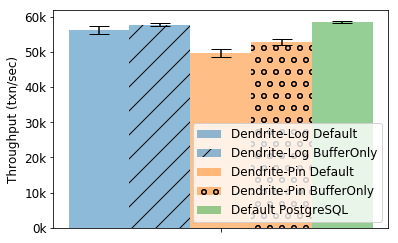

In [50]:
## FIXME: Need Dendrite-Log Results
def k_txn_writer( x, pos ):
    return "{}k".format(int(x))

inds = np.arange(1)
bar_width=0.15
plt.bar( inds-5*bar_width/2, log_default_tput, bar_width, yerr=(log_default_ci,), capsize=10, alpha=0.5, color='#1f77b4', label='Dendrite-Log Default' )
plt.bar( inds-3*bar_width/2, log_buffer_tput, bar_width, yerr=(log_buffer_ci,), alpha=0.5, color='#1f77b4', hatch='/', capsize=10, label='Dendrite-Log BufferOnly' )
plt.bar( inds-bar_width/2, pin_default_tput, bar_width, yerr=(pin_default_ci,), capsize=10, alpha=0.5, color='#ff7f0e', label='Dendrite-Pin Default' )
plt.bar( inds+bar_width/2, pin_buffer_tput, bar_width, yerr=(pin_buffer_ci,), capsize=10, alpha=0.5, hatch='o', color='#ff7f0e', label='Dendrite-Pin BufferOnly' )
plt.bar( inds+3*bar_width/2, default_tput, bar_width, yerr=(default_ci,), capsize=10, alpha=0.5, color='#2ca02c', label='Default PostgreSQL' )
plt.legend( loc='lower right', fontsize=12)
plt.ylabel( "Throughput (txn/sec)", fontsize=12 )
ax = plt.axes()
ax.yaxis.set_major_formatter( tick.FuncFormatter(k_txn_writer))
plt.yticks( fontsize=12 )
plt.xticks( inds-bar_width/2, [""] )
#plt.ylim(40,60)
plt.savefig( 'overheads.png', bbox_inches='tight')
plt.show()